In [1]:
#Pytorch　ResNet　転移学習

#ソース
#https://www.koi.mashykom.com/pytorch.html#fd04
#https://qiita.com/illumination-k/items/fa7508127d8942c1284f
#https://www.oio-blog.com/contents/pytorch-advanced/

In [2]:
from __future__ import print_function, division
import json
from PIL import Image
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os 
import copy
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter 
from datetime import datetime
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#乱数のシード設定
torch.manual_seed(1234)
np.random.seed(1234)
random.seed(1234)

cuda:0


In [3]:

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
#        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# トレーニングのデータのオーギュメンテーションとノーマライズ

# バリデーションのノーマリゼーション

#detaloaderで画像がランダムになるようにする。
#訓練用と検証用のdataloaderを作成し、両者を辞書変数dataloadersに格納する

#GPU使用の宣言
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
 
data_dir = '/home/user/Desktop/Noda/500pixel/500_tumor_no_tumor_divided/500_ly_pos'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


print(dataloaders)
print(dataloaders['train'])

print(dataset_sizes)

print(len(dataloaders['train'].dataset)) #参考サイトにおいて　len(train_loader.dataset) のこと
print(len(dataloaders['val'].dataset)) #len(val_loader.dataset)　のこと　

{'train': <torch.utils.data.dataloader.DataLoader object at 0x14cabfb4de10>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x14ca3c43e0f0>}
{'train': 64912, 'val': 27818}
64912
27818


torch.Size([4, 3, 224, 224])


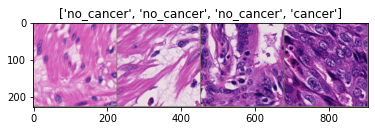

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated
 
# Get a batch of training data
#イテレータの一番目を取り出す。
inputs, classes = next(iter(dataloaders['train']))
 
print(inputs.size())
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
 
imshow(out, title=[class_names[x] for x in classes])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    #現在時刻を取得する
    now = datetime.now()
    since=time.time()

     #pyTorchで構築したネットワークをコピーして使いたい場合、deepcopyを使う
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    # log用フォルダを毎回生成
    # tensorboardの可視化用
    
    log_path = "/home/user/Desktop/Noda/log_register/cancer_no_cancer/" + now.strftime("%Y%m%d-%H%M%S") + "/"
    print(log_path)

    # tensorboard用のwriter
    writer = SummaryWriter(log_path)
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
 
        # 毎エポック毎にトレインとバリデーションを入れる
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
 
            running_loss = 0.0
            running_corrects = 0
 
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
 
                # オプティマイザーを初期化
                optimizer.zero_grad()
 
                # 順伝搬を計算
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
 
                    # 訓練時はバックプロパゲーション
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                #イテレーションの結果の計算
 
                # lossの合計を更新
                running_loss += loss.item() * inputs.size(0)
                #正解数の合計を更新
                running_corrects += torch.sum(preds == labels.data)
             
            if phase == 'train':
                avg_train_loss =  running_loss / len(dataloaders['train'].dataset)
                avg_train_acc = running_corrects/ len(dataloaders['train'].dataset)
            
                
            else:
                avg_val_loss = running_loss / len(dataloaders['val'].dataset)
                avg_val_acc = running_corrects/ len(dataloaders['val'].dataset)
                
                    
            #エポックごとのlossと正解率を表示
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
 
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
             # tensorboard用
            
         

            
            
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        writer.add_scalars('loss', {'train_loss':avg_train_loss, 'val_loss':avg_val_loss},epoch+1)
        writer.add_scalars('accuracy', {'train_acc':avg_train_acc, 'val_acc':avg_val_acc}, epoch+1)
 
        print()
 
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    writer.close()
    
    # 追加部分
    dir_name = 'output'

    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

    model_save_path = os.path.join(dir_name, "model_full.pt")

    # モデル保存
    torch.save(best_model_wts, model_save_path)
 
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model





In [8]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
 
model_ft = model_ft.to(device)
 
criterion = nn.CrossEntropyLoss()
 
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [30]:
# model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
#                        num_epochs=25)

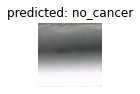

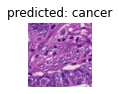

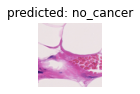

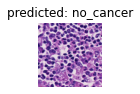

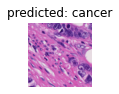

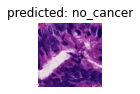

In [9]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
 
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
 
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
 
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
 
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
 
visualize_model(model_ft)
 

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False
 
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)
 
model_conv = model_conv.to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
 
# Observe that only parameters of final layer are being optimized as
# opoosed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
 
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

/home/user/Desktop/Noda/log_register/cancer_no_cancer/20201217-213740/
Epoch 0/24
----------


/home/user/anaconda3/envs/noda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.7098 Acc: 0.6859
val Loss: 0.5637 Acc: 0.7575

Epoch 1/24
----------
train Loss: 0.7199 Acc: 0.6891
val Loss: 0.6505 Acc: 0.7260

Epoch 2/24
----------
train Loss: 0.7067 Acc: 0.6923
val Loss: 0.8190 Acc: 0.7021

Epoch 3/24
----------
train Loss: 0.7230 Acc: 0.6917
val Loss: 0.6088 Acc: 0.7650

Epoch 4/24
----------
train Loss: 0.7242 Acc: 0.6887
val Loss: 0.8893 Acc: 0.6676

Epoch 5/24
----------
train Loss: 0.7198 Acc: 0.6852
val Loss: 0.5530 Acc: 0.7701

Epoch 6/24
----------
train Loss: 0.5452 Acc: 0.7296
val Loss: 0.4726 Acc: 0.7889

Epoch 7/24
----------
train Loss: 0.5331 Acc: 0.7326
val Loss: 0.4817 Acc: 0.7778

Epoch 8/24
----------
train Loss: 0.5334 Acc: 0.7337
val Loss: 0.4475 Acc: 0.7939

Epoch 9/24
----------
train Loss: 0.5317 Acc: 0.7334
val Loss: 0.4738 Acc: 0.7932

Epoch 10/24
----------
train Loss: 0.5306 Acc: 0.7360
val Loss: 0.4584 Acc: 0.7965

Epoch 11/24
----------
train Loss: 0.5285 Acc: 0.7357
val Loss: 0.4598 Acc: 0.7918

Epoch 12/24
----------
t

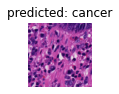

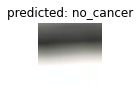

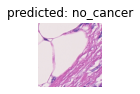

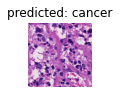

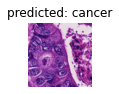

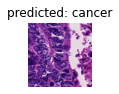

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)
 
visualize_model(model_conv)
 
plt.ioff()
plt.show()



# torch.save(model_conv,"/home/user/Desktop/Noda/log_register/cancer_no_cancer/model_full.pt")

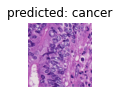

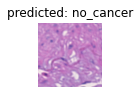

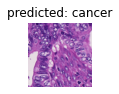

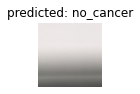

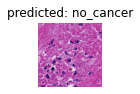

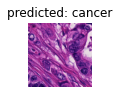

In [13]:
visualize_model(model_conv)

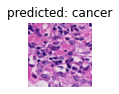

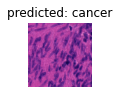

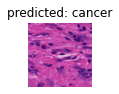

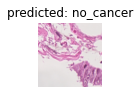

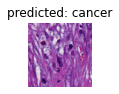

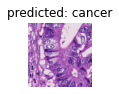

In [18]:
visualize_model(model_conv)
 
plt.ioff()
plt.show()

In [16]:
model_full = torch.load("/home/user/Desktop/Noda/log_register/cancer_no_cancer/model_full.pt")